# **이미지파일로 바운딩박스 그리기 & 캠으로 객체 인식 시키기**

해당 코드는 theAIGuysCode의 github repository를 참고하여 제작되었습니다.

링크: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [ ]:
# clone darknet repo
#https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial.git
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
%cd darknet/data

# fire_data.data 다운로드 
#https://drive.google.com/file/d/11jGe8uuVaO4ArCVPfisr3XKQpmWQzr0U/view?usp=sharing
!gdown --id 11jGe8uuVaO4ArCVPfisr3XKQpmWQzr0U

# test.txt 다운로드 
#https://drive.google.com/file/d/1Gf9Phpjx4zYxYcmHqFxWPynY40TKO9Jm/view?usp=sharing
!gdown --id 1Gf9Phpjx4zYxYcmHqFxWPynY40TKO9Jm

#train.txt 다운로드
#https://drive.google.com/file/d/1VDfQy4QI6MikRjcbLnShIr0Jmzc39ZIs/view?usp=sharing
!gdown --id 1VDfQy4QI6MikRjcbLnShIr0Jmzc39ZIs

#valid.txt
#https://drive.google.com/file/d/1bLDOdSsw2L8Th4LO6ZP9Yv2rGyr7a6O1/view?usp=sharing
!gdown --id 1bLDOdSsw2L8Th4LO6ZP9Yv2rGyr7a6O1

#ClassNames.names 다운로드
#https://drive.google.com/file/d/1E67kBGQelPpELPGwqcyh5avQPNijwiC1/view?usp=sharing
!gdown --id 1E67kBGQelPpELPGwqcyh5avQPNijwiC1

#yolov4-custom_best (1).weight 다운로드 
#https://drive.google.com/file/d/18Wt9F_TNOWqtywGFsp1SHHBeVy6IfPaf/view?usp=sharing
!gdown --id 18Wt9F_TNOWqtywGFsp1SHHBeVy6IfPaf

100% 256M/256M [00:00<00:00, 292MB/s]


In [ ]:
#https://drive.google.com/file/d/1E67kBGQelPpELPGwqcyh5avQPNijwiC1/view?usp=sharing
!gdown --id 1E67kBGQelPpELPGwqcyh5avQPNijwiC1

In [ ]:
#https://drive.google.com/file/d/18Wt9F_TNOWqtywGFsp1SHHBeVy6IfPaf/view?usp=sharing
!gdown --id 18Wt9F_TNOWqtywGFsp1SHHBeVy6IfPaf

## 3) .cfg 파일 수정

In [ ]:
# 변경사항이 반영이 되었는지 확인하여보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=1
subdivisions=64
width=608
height=608
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 5500
policy=steps
steps=4400,4950
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation

In [ ]:
#set your custom cfg to test mode 
%cd /content/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [ ]:
%cat /content/darknet/data/fire_data.data

classes = 11
train = data/train.txt
valid = data/valid.txt
test = data/test.txt
names = data/ClassNames.names
backup = backup/

## 5) darknet 구축

In [ ]:
# GPU, OPENCV, LIBSO을 true로 설정
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

## 2) Darknet for Python



In [ ]:
!pwd

/content/darknet


In [ ]:
from darknet import *

In [ ]:
# YOLOv4 모델을 로드하여보자.
# 커스텀 모델을 사용할 경우 load_network의 1번째, 3번째 인자를 수정해야 한다.
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/fire_data.data", "data/yolov4-custom_best_1.weights")

    (참고)
    .cfg 파일은 다양한 프로그램 환경에서 각자의 소프트웨어에 특정한 설정을 저장하는 데 사용되는 파일 형식

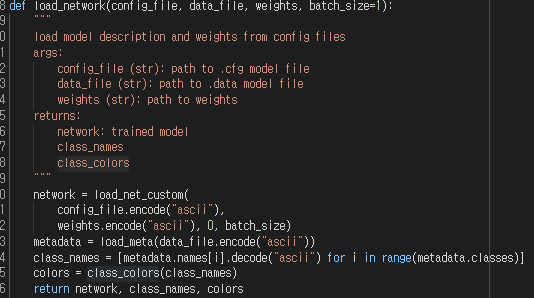

* darknet.py 파일을 확인해보면 load_network 함수의 1번째 인자는 config file, 2번째 인자는 data file, 3번째 인자는 weights에 해당하는 것을 알 수 있다.
* 또한 load_network 함수는 학습된 모델(=network), class 이름(=class names), class 별 고유 색상(=class colors)를 반환하는 것을 알 수 있다.
* class colors는 이후 boundary box를 이미지 위에 시각화할 때 사용할 색상이다.

In [ ]:
# class의 종류 예시
class_names

['00_Not_related',
 '01_Black_smoke',
 '02_Gray_smoke ',
 '03_White_smoke',
 '04_Fire',
 '05_Cloud',
 '06_Fog',
 '07_Light',
 '08_Sunlight',
 '09_Wobbling_object',
 '10_Leaves_&_grasses']

In [ ]:
# class color의 예시
class_colors['01']

KeyError: ignored

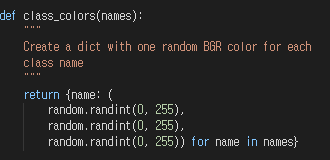

* 3가지의 값은 각각 B(Black), G(Green), R(Red)에 해당하는 것은 알 수 있다.
* 또한 색상은 랜덤하게 배정이 되었으며, 딕셔너리 형태로 클래스 별 생상 데이터가 저장되었음을 알 수 있다.
* 참고: OpenCV는 일반적인 RGB 순서가 아닌 BGR을 사용한다.

In [ ]:
# 네트워크의 width와 height을 계산
width = network_width(network)
height = network_height(network)

print(width, height)

608 608


In [ ]:
# object detection을 수행하는 darknet_helper 함수를 살펴보자.

def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산 
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

In [ ]:
# 파일 업로드 기능 실행
files.upload()

`cv2.imread(이미지 경로, 모드)`
* 이미지를 BGR 형식으로 읽는 함수이다.
*  모드로는 IMREAD_UNCHAGNED (=원본), IMREAD_GRAYSCALE(=흑백), IMREAD_COLOR (=BGR 이미지), IMREAD_REDUCED_GRAYSCALE_2 (=2/1 크기의 흑백 이미지) 등이 있다. (기본 값 = IMREAD_UNCHAGED)


`matplotlib.pyplot.imshow(RGB 데이터 또는 2d scalaer 데이터)`

* imread() 함수를 사용하여 jpg 등 이미지 파일을 읽어온 후, imshow() 함수를 사용하여 이미지를 출력할 수 있다.


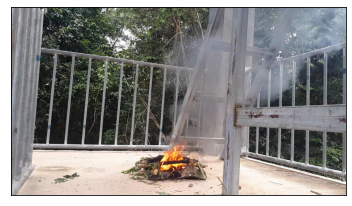

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/darknet/S3-N1213MF02382.jpg')
#RGB 이미지를 BGR로 변환
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(imagee) 
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show() 

## 3) YOLOv4 Example on Test Image


In [ ]:
# darknet_helper 함수에 앞서 읽은 이미지와 network height, width를 입력
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)

In [ ]:
# detection 결과 확인
detections

[('05_Cloud',
  '1.18',
  (302.86029052734375,
   209.72738647460938,
   702.46533203125,
   401.2769470214844)),
 ('05_Cloud',
  '1.32',
  (496.3019104003906,
   236.82522583007812,
   227.73007202148438,
   535.3541870117188)),
 ('06_Fog',
  '1.35',
  (496.1328125, 214.4936981201172, 241.14578247070312, 482.9804992675781)),
 ('00_Not_related',
  '1.41',
  (281.0671081542969,
   585.0006713867188,
   166.272705078125,
   44.872432708740234)),
 ('05_Cloud',
  '1.62',
  (210.2922821044922, 271.993896484375, 397.3668212890625, 343.4483947753906)),
 ('05_Cloud',
  '1.82',
  (304.4147644042969,
   79.34606170654297,
   700.7957763671875,
   147.92990112304688)),
 ('06_Fog',
  '2.96',
  (303.84820556640625,
   56.43797302246094,
   685.97802734375,
   105.83500671386719)),
 ('08_Sunlight',
  '6.61',
  (496.3019104003906,
   236.82522583007812,
   227.73007202148438,
   535.3541870117188))]

* 튜플 형태 ("클래스 이름", class confidence, bounding box)로 결과가 저장된 것을 확인할 수 있다.
* bounding box로 나온 4가지 수치는 center x, center y, width, height에 해당한다. 

In [ ]:
width_ratio, height_ratio

(0.8585526315789473, 1.106907894736842)

`cv2.rectangle(image, start, end, color, thickness)`
* 이미지에 start와 end를 연결하는 사각형을 그린다.
* image는 사각형을 그릴 이미지를 입력하는 인자이다.
* start는 top-left corner의 좌표를 입력하는 인자이다.
* end는 bottom-right corner의 좌표를 입력하는 인자이다.

`cv2.putText(img, text, org, font, fontSacle, color)`
* 이미지에 text를 입력한다.
* text는 텍스트를 입력하는 인자이다.
* org는 테스트를 표시할 위치를 입력하는 인자로 문자열의 bottom-left corner 좌표를 입력한다.

In [ ]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

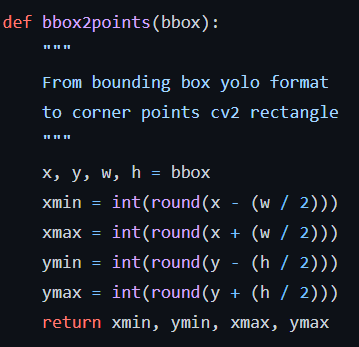

* center x, center y, width, height로 반환 받은 boundary box를 corner 정보로 변환하는 함수는 위와 같다. 

## 4) Helper Functions



* 웹캠을 구글 코랩에서 사용하기 위해서는 Javascript 코드를 실행하여야 한다. 따라서 OpenCV 파일을 Javascript 객체로 변환하고 그 반대로도 변환하는 함수를 생성하여 보자.
* 웹캠은 Javascript 코드를 사용하는 반면, bounding box는 OpenCV 형식이다.

`base64.b64decode(s, altchars=None, validate=False)`

* Base64로 인코딩된 바이트열류 객체나 ASCII 문자열 s를 디코딩하고 디코딩된 bytes를 반환한다.

In [ ]:
# JavaScript 객체를 OpenCV 이미지 유형으로 변환
def js_to_image(js_reply):
  """
  파라미터:
          js_reply: JavaScript 객체 (Base64 진법의 문자열)
  반환:
          img:  OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  """

  # 64진법으로 인코딩된 Javascript 객체를 바이트로 디코딩 
  image_bytes = b64decode(js_reply.split(',')[1])
  # 바이트를 넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

`.save(fp, format=None)`
* PIL 형식의 이미지를 저장한다. 
* fp: 파일명/파일 주소/파일 객체
* format: 파일 저장 형식, 아무 입력이 없을 경우 파일명에 포함된 파일 형식으로 저장된다. fp에 파일명 대신 파일 객체가 입력되었을 경우 format 형식을 명시하는 것이 필수적이다. 

In [ ]:
# OpenCV 사각형(Bounding Box) 이미지를 JavaScript 객체로 변환
def bbox_to_bytes(bbox_array):
  """
  파라미터:
          bbox_array: OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  반환:
        바이트: JavaScript 객체 (Base64 진법의 문자열)
  """
  # 넘파일 배열을 PIL(Python Image Library) 이미지로 변환 
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  # 문자열(바이트 배열)을 이진 파일로 읽을 수 있는 BytesIO 객체 생성
  iobuf = io.BytesIO()
  # PIL 이미지 형태의 boundary box를 png 파일로 변환하여 저장 
  bbox_PIL.save(iobuf, format='png')
  # JavaScript 객체 반환
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## YOLOv4 on Wecam Images

 

코드 스니펫

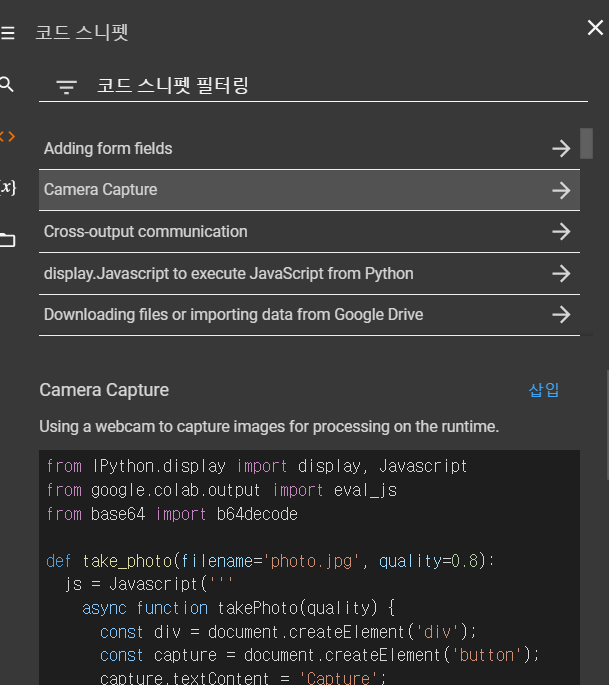

`eval_js()`
* 자바 스크립트 함수를 실행한다.
* 이를 통해 파이썬 내부에서 바로 사용할 수 있다.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):

  # 자바스크립트를 사용하여 local webcam에 access 
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // 결과를 resize
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // 클릭하여 이미지 캡쳐
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # YOLO v4 detection 수행

  # javascrip 이미지를 입력
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV 형식의 이미지로 변환
  img = js_to_image(data) 
  
  # 앞서 정의했던 darknet helper 함수에 웹캠 이미지를 삽입
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # detection을 통해 얻은 boundary boxes를 웹캠 이미지에 표시
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # 이미지를 저장
  cv2.imwrite(filename, img)

  return filename

* take_photo 실행 시 웹캠 권한을 묻는 메시지가 뜬다.

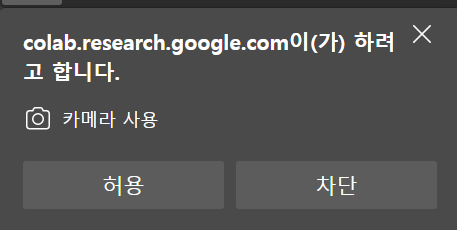

* 허용 버튼을 클릭하면 웹캠 이미지와 캡쳐 버튼이 생성된다.

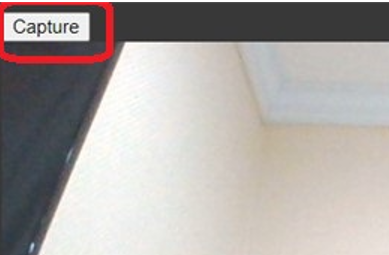

*이탤릭체 텍스트*## YOLOv4 on Webcam Videos





아래는 영상 스트리밍을 실행하는 자바스크립트 코드이다. 영상의 프레임은 YOLOv4의 입력으로 주어지게 된다.

In [ ]:
!git clone https://github.com/theAIGuysCode/tensorflow-yolov4-tflite

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 912, done.
remote: Total 912 (delta 0), reused 0 (delta 0), pack-reused 912
Receiving objects: 100% (912/912), 211.46 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (441/441), done.


In [ ]:
%cd /content/darknet/tensorflow-yolov4-tflite

/content/darknet/tensorflow-yolov4-tflite


In [ ]:
!pip install -r requirements-gpu.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 492.1 MB 11 kB/s 
     |████████████████████████████████| 28.7 MB 107.5 MB/s 
     |████████████████████████████████| 5.8 MB 6.8 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.7.0 which is incompatible.


In [ ]:
%cd /content/darknet/tensorflow-yolov4-tflite/scripts

/content/darknet/tensorflow-yolov4-tflite/scripts


In [ ]:
# yolov4.weights file 다운로드
!gdown --id 1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT 



In [ ]:
%cd ..

/content/darknet/tensorflow-yolov4-tflite


In [ ]:
# darknet weights -> tensorflow 형식으로 변환
## yolov4
!python save_model.py --weights ./data/yolov4.weights --output ./checkpoints/yolov4-416 --input_size 416 --model yolov4 

2022-09-01 07:54:26.652183: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Traceback (most recent call last):
  File "save_model.py", line 58, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "save_model.py", line 54, in main
    save_tf()
  File "save_model.py", line 49, in save_tf
    utils.load_weights(model, FLAGS.weights, FLAGS.model, FLAGS.tiny)
  File "/content/darknet/tensorflow-yolov4-tflite/core/utils.py", line 36, in load_weights
    wf = open(weights_file, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: './data/yolov4.weights'


In [ ]:
# yolov4 tensorflow model 실행
!python detect.py --weights ./checkpoints/yolov4-416 --size 416 --model yolov4 --images ./data/images/dog.jpg

Traceback (most recent call last):
  File "detect.py", line 107, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "detect.py", line 41, in main
    saved_model_loaded = tf.saved_model.load(FLAGS.weights, tags=[tag_constants.SERVING])
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/load.py", line 936, in load
    result = load_internal(export_dir, tags, options)["root"]
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/load.py", line 949, in load_internal
    loader_impl.parse_saved_model_with_debug_info(export_dir))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/loader_impl.py", line 57, in parse_saved_model_with_debug_info
    saved_model = parse_saved_model(export_dir)
  File "/usr/local/lib/python3.7/

In [ ]:
# https://drive.google.com/file/d/1s8CTgK8VahSJNxPQ1JdZWjOhshlsnsQX/view?usp=sharing
!gdown --id 1s8CTgK8VahSJNxPQ1JdZWjOhshlsnsQX


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1s8CTgK8VahSJNxPQ1JdZWjOhshlsnsQX
To: /content/darknet/tensorflow-yolov4-tflite/KakaoTalk_20220901_155202412.mp4
100% 3.53M/3.53M [00:00<00:00, 173MB/s]


In [ ]:
!python detect_video.py --weights ./checkpoints/yolov4-416 --size 416 --model yolov4 --video ./data/video/video.mp4 --output ./detections/results.mp4

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.00

In [ ]:
# 실시간 영상 스트리밍을 작동시키는 JavaScript 코드
def video_stream():
  js = Javascript('''
    var video;
    var div = null; 
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
frame.shape

NameError: ignored

In [ ]:
# 웹캠에서 영상 스트리밍을 시작
video_stream()
# label for video
label_html = 'Capturing...'
# bounding box 초기화 
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # javascript 객체를 OpenCV 이미지로 변환 
    frame = js_to_image(js_reply["img"])
    

    # bounding box를 위한 투명 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 앞서 정의하였던 darknet helper 함수를 실행 
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # detection 결과를 순회하며 결과를 overlay 이미지에 표시
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bounding box의 overlay를 바이트로 변환
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bounding box를 업데이트하여 다음 프레임이 새로운 overlay를 갖도록 함
    bbox = bbox_bytes

NameError: ignored